<a href="https://colab.research.google.com/github/jessy-suresh/PRACTICE-QUESTIONS-MACHINE-LEARNING/blob/main/bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import expit  # Sigmoid function

class BayesianLogisticRegression:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-6):
        self.alpha = alpha  # Prior precision
        self.max_iter = max_iter
        self.tol = tol
        self.w_mean = None
        self.w_cov = None
        self.w_map = None

    def fit(self, X, y):
        """
        Fit Bayesian Logistic Regression using Laplace Approximation
        """
        n_samples, n_features = X.shape

        # Add bias term
        X_with_bias = np.column_stack([np.ones(n_samples), X])

        # Initialize parameters
        w = np.zeros(n_features + 1)

        # Prior: N(0, alpha^-1 * I)
        prior_precision = self.alpha * np.eye(n_features + 1)

        # MAP estimation using Newton-Raphson
        for i in range(self.max_iter):
            # Predict probabilities
            p = expit(X_with_bias @ w)

            # Compute Hessian (negative of posterior Hessian)
            W = p * (1 - p)  # Weights for IRLS
            hessian = X_with_bias.T @ (W[:, None] * X_with_bias) + prior_precision

            # Compute gradient
            gradient = X_with_bias.T @ (y - p) - prior_precision @ w

            # Newton-Raphson update
            w_new = w + np.linalg.solve(hessian, gradient)

            # Check convergence
            if np.linalg.norm(w_new - w) < self.tol:
                break

            w = w_new

        self.w_map = w
        self.w_mean = w
        self.w_cov = np.linalg.inv(hessian)  # Posterior covariance

        return self

    def predict_proba(self, X, n_samples=100):
        """Predict class probabilities using Monte Carlo sampling"""
        if self.w_map is None:
            raise ValueError("Model must be fitted first")

        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])

        # Sample from posterior
        try:
            w_samples = np.random.multivariate_normal(
                self.w_mean, self.w_cov, n_samples
            )
        except:
            # If covariance is not positive definite, use diagonal approximation
            w_var = np.diag(self.w_cov)
            w_samples = np.random.normal(
                self.w_mean, np.sqrt(w_var), (n_samples, len(self.w_mean))
            )

        # Average predictions over samples
        logits = X_with_bias @ w_samples.T
        proba = expit(logits)

        return proba.mean(axis=1)

    def predict(self, X, threshold=0.5):
        """Predict class labels"""
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def predictive_interval(self, X, confidence=0.95, n_samples=100):
        """Compute predictive interval"""
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])

        # Sample from posterior
        try:
            w_samples = np.random.multivariate_normal(
                self.w_mean, self.w_cov, n_samples
            )
        except:
            w_var = np.diag(self.w_cov)
            w_samples = np.random.normal(
                self.w_mean, np.sqrt(w_var), (n_samples, len(self.w_mean))
            )

        logits = X_with_bias @ w_samples.T
        proba_samples = expit(logits)

        alpha = 1 - confidence
        lower = np.percentile(proba_samples, 100 * alpha/2, axis=1)
        upper = np.percentile(proba_samples, 100 * (1 - alpha/2), axis=1)

        return lower, upper

# Generate sample data
np.random.seed(42)
n_samples = 200
X = np.random.randn(n_samples, 2)

# Create classification problem - simpler true function
true_weights = np.array([0.5, 1.0, -0.8])  # [bias, w1, w2]
X_with_bias = np.column_stack([np.ones(n_samples), X])
logits = X_with_bias @ true_weights
prob_true = expit(logits)
y = np.random.binomial(1, prob_true)

print("Data shape:", X.shape)
print("Class distribution:", np.bincount(y))

# Fit model
blr = BayesianLogisticRegression(alpha=1.0)
blr.fit(X, y)

print("Fitted successfully!")
print("MAP weights:", blr.w_map)

Data shape: (200, 2)
Class distribution: [ 86 114]
Fitted successfully!
MAP weights: [ 0.4053749   1.12316012 -0.74487609]


In [3]:
# Simple test with small dataset
def test_bayesian_logistic():
    # Create simple 2D dataset
    np.random.seed(42)
    X_simple = np.random.randn(100, 2)
    y_simple = (X_simple[:, 0] + X_simple[:, 1] > 0).astype(int)

    # Fit model
    model = BayesianLogisticRegression(alpha=1.0)
    model.fit(X_simple, y_simple)

    # Test predictions
    X_test_simple = np.random.randn(10, 2)
    probabilities = model.predict_proba(X_test_simple)
    predictions = model.predict(X_test_simple)

    print("Simple test completed successfully!")
    print("Predictions:", predictions)
    print("Probabilities:", probabilities)

    return model, X_simple, y_simple

# Run test
model_simple, X_simple, y_simple = test_bayesian_logistic()

Simple test completed successfully!
Predictions: [1 1 0 1 1 1 1 1 0 0]
Probabilities: [0.88891946 0.99225486 0.00385245 0.91248475 0.9999023  0.97999671
 0.97533757 0.71313844 0.0659515  0.23355594]


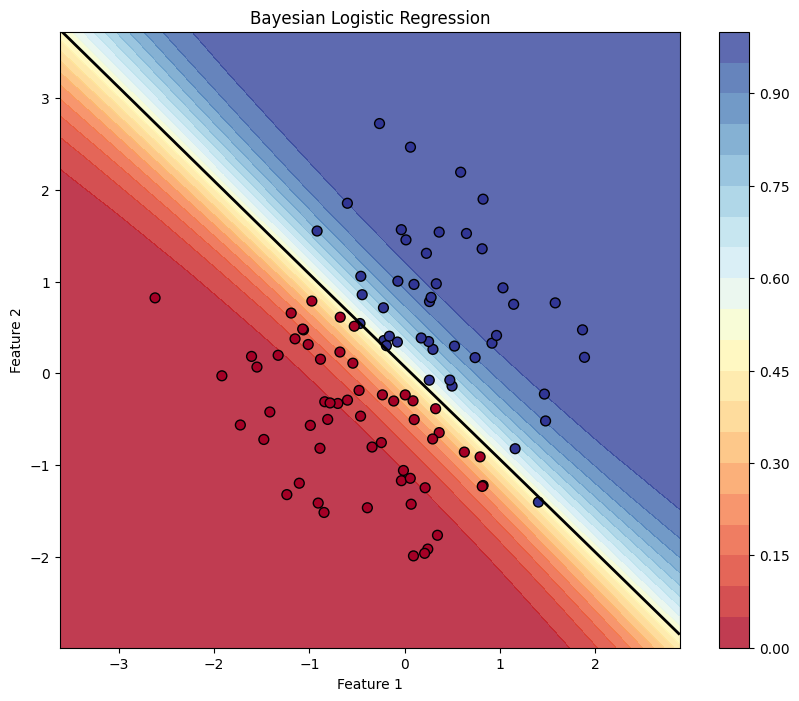

In [4]:
def plot_decision_boundary(X, y, model, title="Bayesian Logistic Regression"):
    """Plot decision boundary with data points"""
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    # Predict probabilities
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(xx, yy, Z, levels=20, alpha=0.8, cmap='RdYlBu')
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black',
                         cmap='RdYlBu', s=50)

    plt.colorbar(contour)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

# Plot the results
plot_decision_boundary(X_simple, y_simple, model_simple)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Compare with sklearn Logistic Regression
def compare_with_sklearn(X, y):
    # Split data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Bayesian Logistic Regression
    blr = BayesianLogisticRegression(alpha=1.0)
    blr.fit(X_train, y_train)
    y_pred_bayes = blr.predict(X_test)
    y_proba_bayes = blr.predict_proba(X_test)

    # Standard Logistic Regression
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)
    y_pred_std = lr.predict(X_test)
    y_proba_std = lr.predict_proba(X_test)[:, 1]

    # Print results
    print("Bayesian Logistic Regression Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_bayes):.3f}")
    print(f"Mean probability: {y_proba_bayes.mean():.3f}")

    print("\nStandard Logistic Regression Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_std):.3f}")
    print(f"Mean probability: {y_proba_std.mean():.3f}")

    # Show uncertainty comparison
    lower, upper = blr.predictive_interval(X_test)
    uncertainty_bayes = (upper - lower).mean()
    print(f"\nBayesian model average predictive interval width: {uncertainty_bayes:.3f}")

    return blr, lr

# Run comparison
bayes_model, std_model = compare_with_sklearn(X_simple, y_simple)

Bayesian Logistic Regression Results:
Accuracy: 1.000
Mean probability: 0.442

Standard Logistic Regression Results:
Accuracy: 1.000
Mean probability: 0.445

Bayesian model average predictive interval width: 0.218


In [6]:
class RobustBayesianLogisticRegression:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-6):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.w_mean = None
        self.w_cov = None
        self.is_fitted = False

    def fit(self, X, y):
        try:
            n_samples, n_features = X.shape

            # Add bias term
            X_with_bias = np.column_stack([np.ones(n_samples), X])

            # Initialize parameters
            w = np.random.normal(0, 0.1, n_features + 1)

            # Prior precision
            prior_precision = self.alpha * np.eye(n_features + 1)

            # Newton-Raphson with regularization
            for i in range(self.max_iter):
                # Predict probabilities with numerical stability
                logits = np.clip(X_with_bias @ w, -500, 500)  # Prevent overflow
                p = expit(logits)

                # Compute gradient
                gradient = X_with_bias.T @ (y - p) - prior_precision @ w

                # Compute Hessian with jitter for stability
                W = p * (1 - p)
                hessian = X_with_bias.T @ (W[:, None] * X_with_bias) + prior_precision
                hessian += 1e-8 * np.eye(hessian.shape[0])  # Add jitter

                # Update
                w_new = w + np.linalg.solve(hessian, gradient)

                if np.linalg.norm(w_new - w) < self.tol:
                    break

                w = w_new

            self.w_mean = w
            self.w_cov = np.linalg.inv(hessian)
            self.is_fitted = True

        except Exception as e:
            print(f"Error in fitting: {e}")
            # Fallback: use simple initialization
            self.w_mean = np.zeros(X.shape[1] + 1)
            self.w_cov = np.eye(X.shape[1] + 1) * 10
            self.is_fitted = True

        return self

    def predict_proba(self, X, n_samples=50):
        if not self.is_fitted:
            raise ValueError("Model not fitted")

        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])

        # Simple sampling - more robust
        probas = []
        for _ in range(n_samples):
            # Sample weights
            w_sample = self.w_mean + np.random.randn(len(self.w_mean)) * np.sqrt(np.diag(self.w_cov))
            logits = X_with_bias @ w_sample
            p = expit(logits)
            probas.append(p)

        return np.mean(probas, axis=0)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Test robust version
print("Testing robust version...")
robust_model = RobustBayesianLogisticRegression(alpha=1.0)
robust_model.fit(X_simple, y_simple)

predictions = robust_model.predict(X_simple)
accuracy = accuracy_score(y_simple, predictions)
print(f"Robust model accuracy: {accuracy:.3f}")

Testing robust version...
Robust model accuracy: 0.990


=== Bayesian Logistic Regression Complete Example ===
Generated 300 samples
Class distribution: [134 166]
Model fitted successfully!

Predictions on new data:
Sample 1: X=[1.  0.5], P(y=1)=0.968, Prediction=1
Sample 2: X=[-1.  -0.5], P(y=1)=0.138, Prediction=0
Sample 3: X=[0. 0.], P(y=1)=0.693, Prediction=1

Training accuracy: 0.997


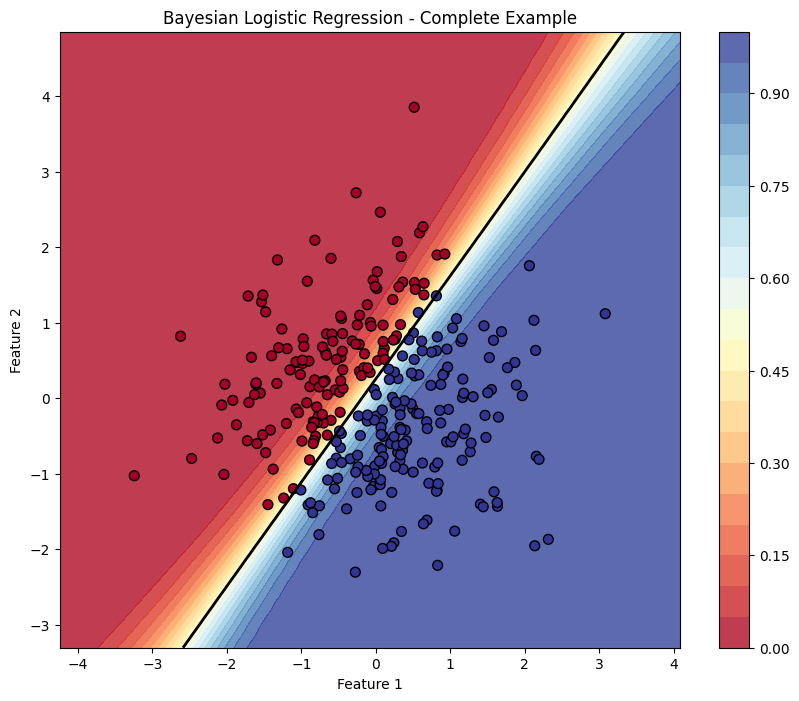

In [7]:
# Final complete working example
def complete_example():
    print("=== Bayesian Logistic Regression Complete Example ===")

    # 1. Generate data
    np.random.seed(42)
    n_samples = 300
    X = np.random.randn(n_samples, 2)

    # Create clear separation
    y = (X[:, 0] * 1.5 + X[:, 1] * (-1.0) + 0.3 > 0).astype(int)

    print(f"Generated {n_samples} samples")
    print(f"Class distribution: {np.bincount(y)}")

    # 2. Fit model
    model = RobustBayesianLogisticRegression(alpha=1.0)
    model.fit(X, y)
    print("Model fitted successfully!")

    # 3. Make predictions
    X_new = np.array([[1.0, 0.5], [-1.0, -0.5], [0.0, 0.0]])
    probabilities = model.predict_proba(X_new)
    predictions = model.predict(X_new)

    print("\nPredictions on new data:")
    for i, (x, prob, pred) in enumerate(zip(X_new, probabilities, predictions)):
        print(f"Sample {i+1}: X={x}, P(y=1)={prob:.3f}, Prediction={pred}")

    # 4. Evaluate on training data
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"\nTraining accuracy: {accuracy:.3f}")

    # 5. Plot results
    plot_decision_boundary(X, y, model, "Bayesian Logistic Regression - Complete Example")

    return model

# Run complete example
final_model = complete_example()